In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Import Dependencies
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Ok, let's get started. This is my first Kaggle project. I have decided to start my DS and ML journey with the Titanic Dataset which is a good way to introduce feature engineering and ensemble modeling.


****Overview****


* Understand the shape of the data (Histograms, box plots, etc.)
* Data Cleaning
* Data Exploration
* Feature Engineering
* Data Preprocessing for Model
* Basic Model Building
* Model Tuning
* Ensemble Modle Building
* Results

I want to thank Ken Jee for this Project Planning, a lot of the features I will be using in this notebook are inspired by his tutorial.

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Let's see what is the ratio of the women who have survived:

In [4]:
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


What about the men?

In [5]:
men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [6]:
#we will combime the data
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

# Data description 

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

# **Light Data Exploration**


# **1) For numeric data**
*     Made histograms to understand distributions
*     Corrplot
*     Pivot table comparing survival rate across numeric variables


# **2) For Categorical Data**
*     Made bar charts to understand balance of classes
*     Made pivot tables to understand relationship with survival

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [8]:
#let's separate the numarical values from the categotical ones

df_num= train[['Age','SibSp','Parch','Fare']]
df_cat= train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

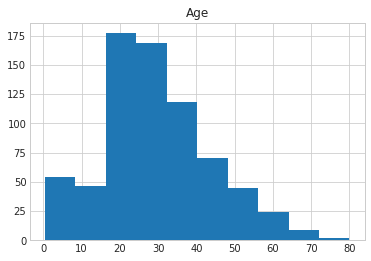

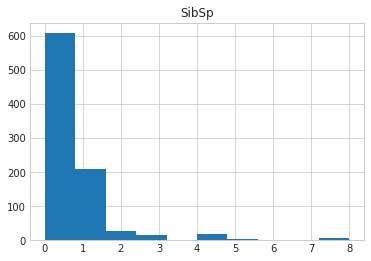

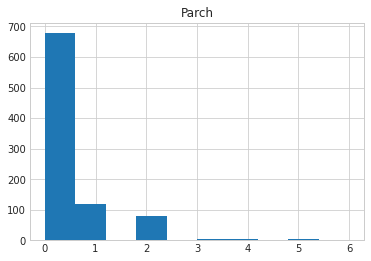

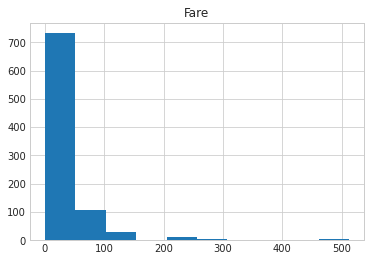

In [9]:
#make histograms for the num variables
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

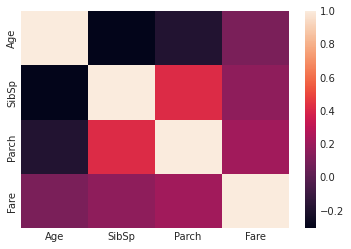

In [10]:
#make corrplot for the num variables
print(df_num.corr())
sns.heatmap(df_num.corr())

In [11]:
#pivot table
pd.pivot_table(train, index='Survived', values=['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


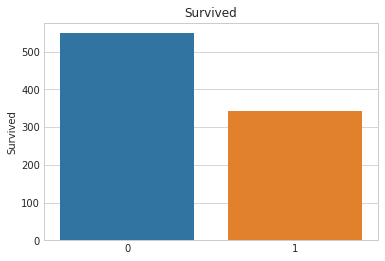

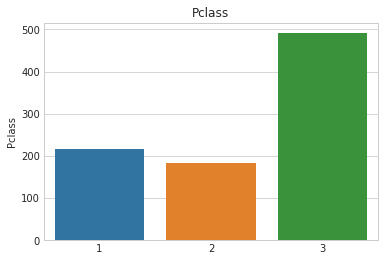

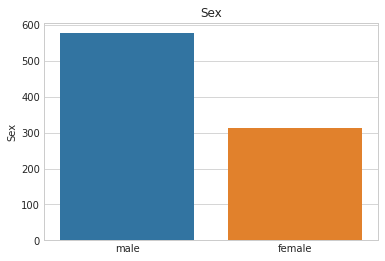

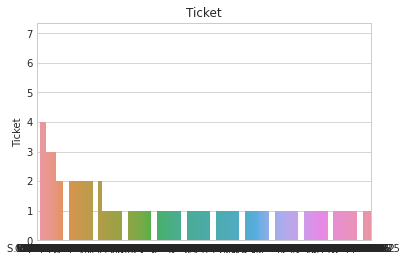

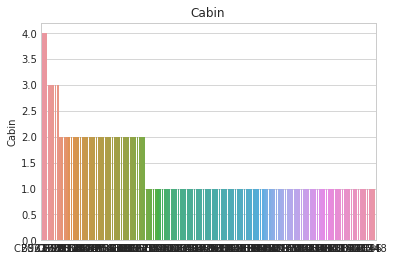

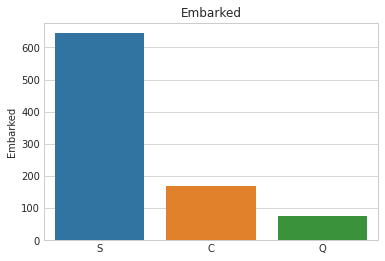

In [12]:
#make barplots for the cat variables
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

In [13]:
#pivot tables
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


# Does a person's title relate to survival rates?

In [14]:
train.Name.head(50)
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [15]:
train['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

In [16]:
features1 = train['name_title'].value_counts().keys()
features1

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col',
       'the Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'],
      dtype='object')

In [17]:
test.Name.head(50)
test['name_title'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [18]:
test['name_title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: name_title, dtype: int64

In [19]:
features2 = test['name_title'].value_counts().keys()
list(features2)

['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Rev', 'Ms', 'Dr', 'Dona']

In [20]:
features = list(features1) + list(features2)
features = set(features)
features

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [21]:
features_one_hot = pd.get_dummies(train['name_title'], drop_first=True)
features_one_hot.head()

,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [22]:
train = pd.concat([train, features_one_hot], axis=1)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,1,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,0,0,0,0,0,0,1,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,0,1,0,0,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,0,1,0,0,0,0,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,0,0,0,0,1,0,0,0,0,0


In [23]:
features_one_hot = pd.get_dummies(test['name_title'], drop_first=True)
test = pd.concat([test, features_one_hot], axis=1)
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Survived,name_title,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,NaN,Mrs,0,0,0,0,0,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,NaN,Mrs,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,NaN,Dona,1,0,0,0,0,0,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,...,NaN,Mr,0,0,0,0,1,0,0,0


Now that we have the passager's titles, we can drop the Name and the PassagerId columns.

In [24]:
train.drop(['PassengerId','Name'],axis=1,inplace= True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0,0,0,0,1,0,0,0,0,0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,0,1,0,0,0,0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,0,1,0,0,0,0,0,0,0,0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,0,1,0,0,0,0
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,...,0,0,0,0,1,0,0,0,0,0


In [25]:
test.drop(['PassengerId','Name'],axis=1,inplace= True)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Survived,name_title,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
0,3,male,34.5,0,0,330911,7.8292,NaN,Q,0,NaN,Mr,0,0,0,0,1,0,0,0
1,3,female,47.0,1,0,363272,7.0000,NaN,S,0,NaN,Mrs,0,0,0,0,0,1,0,0
2,2,male,62.0,0,0,240276,9.6875,NaN,Q,0,NaN,Mr,0,0,0,0,1,0,0,0
3,3,male,27.0,0,0,315154,8.6625,NaN,S,0,NaN,Mr,0,0,0,0,1,0,0,0
4,3,female,22.0,1,1,3101298,12.2875,NaN,S,0,NaN,Mrs,0,0,0,0,0,1,0,0


# What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

<AxesSubplot:>

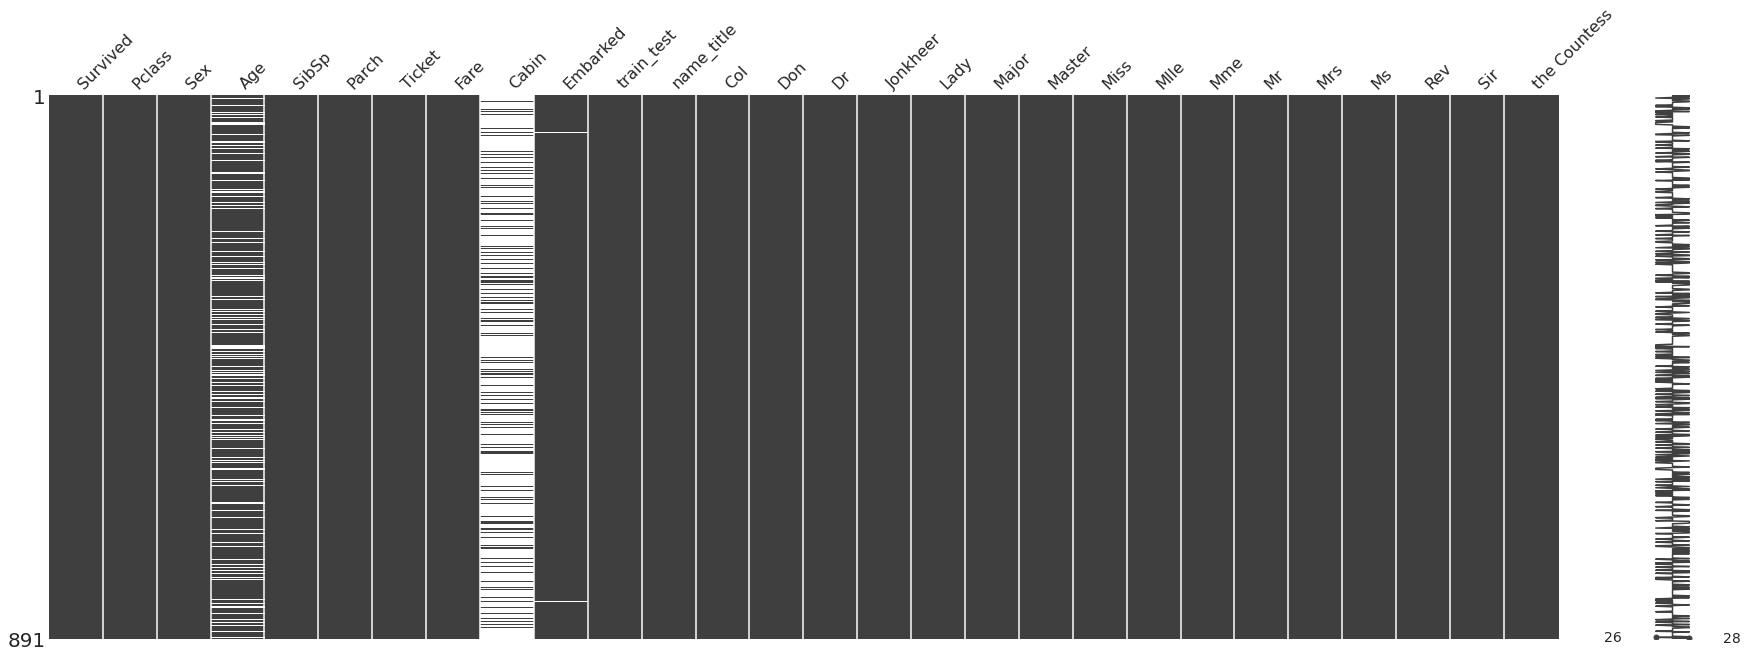

In [26]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [27]:
train.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
train_test        0
name_title        0
Col               0
Don               0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr                0
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
dtype: int64

In [28]:
test.isnull().sum()

Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin         327
Embarked        0
train_test      0
Survived      418
name_title      0
Dona            0
Dr              0
Master          0
Miss            0
Mr              0
Mrs             0
Ms              0
Rev             0
dtype: int64

In [29]:
# add Sex to the subset dataframes
train['Sex'] = np.where(train['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

test['Sex'] = np.where(test['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

In [30]:
train[train['Age'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
5,0,3,0,NaN,0,0,330877,8.4583,NaN,Q,...,0,0,0,0,1,0,0,0,0,0
17,1,2,0,NaN,0,0,244373,13.0000,NaN,S,...,0,0,0,0,1,0,0,0,0,0
19,1,3,1,NaN,0,0,2649,7.2250,NaN,C,...,0,0,0,0,0,1,0,0,0,0
26,0,3,0,NaN,0,0,2631,7.2250,NaN,C,...,0,0,0,0,1,0,0,0,0,0
28,1,3,1,NaN,0,0,330959,7.8792,NaN,Q,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,0,NaN,0,0,2629,7.2292,NaN,C,...,0,0,0,0,1,0,0,0,0,0
863,0,3,1,NaN,8,2,CA. 2343,69.5500,NaN,S,...,0,1,0,0,0,0,0,0,0,0
868,0,3,0,NaN,0,0,345777,9.5000,NaN,S,...,0,0,0,0,1,0,0,0,0,0
878,0,3,0,NaN,0,0,349217,7.8958,NaN,S,...,0,0,0,0,1,0,0,0,0,0


We decided to use the median age for each gender within each passenger class as a proxy. Below, we replace the NaNs with our new estimates.

In [31]:
meanAgeTrain = train.groupby(['Pclass', 'Sex'])['Age'].transform('mean')
    
for df in [train, test]:
    df['Age'] = df['Age'].fillna(meanAgeTrain)

In [32]:
train.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
train_test        0
name_title        0
Col               0
Don               0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr                0
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
dtype: int64

In [33]:
pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')


Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [34]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [35]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0,0,0,0,1,0,0,0,0,0
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,0,1,0,0,0,0
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,0,1,0,0,0,0,0,0,0,0
3,1,1,1,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,0,1,0,0,0,0
4,0,3,0,35.0,0,0,373450,8.0500,NaN,S,...,0,0,0,0,1,0,0,0,0,0


In [36]:
train.dropna(subset=['Embarked'],inplace = True)

# Preprocessing

In [37]:
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data.drop('Cabin', axis=1, inplace= True)
all_data.Age = all_data.Age.fillna(train.Age.mean())
all_data.dropna(subset=['Embarked'],inplace = True)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','name_title','train_test']])
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

(889,)

In [38]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

# Model Building (Baseline Validation Performance)
* Logistic Regression
* Decision Tree
* K Nearest Neighbor
* Support Vector Classifier

In [39]:
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [40]:
#logistic regression
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression(max_iter = 2000)
grid_search_lr = GridSearchCV(
    estimator = lr,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10
)
# execute search
logreg_cv = grid_search_lr.fit(X_train_scaled ,y_train)

In [41]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8234550561797753


In [42]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
grid_search_tree = GridSearchCV(
    estimator = tree,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10
)
tree_cv = grid_search_tree.fit(X_train_scaled,y_train)

In [43]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.830196629213483


In [44]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator = KNN,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10
)
knn_cv = grid_search_knn.fit(X_train_scaled,y_train)

In [45]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8301710929519919


In [46]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',  
              'Decision Tree'],
    'Score': [
        knn_cv.best_score_,
        tree_cv.best_score_,
        logreg_cv.best_score_
        
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
1,Logistic Regression,0.830197
0,KNN,0.830171
2,Decision Tree,0.823455


Best model is KNN with a score of 0.830171

# Submission

In [47]:
X_test_scaled

,Pclass,Age,SibSp,Parch,norm_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,name_title_Sir,name_title_the Countess
0,3,0.371161,-0.479537,-0.445407,-0.826065,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,3,1.343357,0.480272,-0.445407,-0.928006,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,2.509992,-0.479537,-0.445407,-0.628629,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,3,-0.212157,-0.479537,-0.445407,-0.732843,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,3,-0.601035,0.480272,0.709647,-0.403554,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,-0.035441,-0.479537,-0.445407,-0.800534,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
414,1,0.721152,-0.479537,-0.445407,1.780269,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
415,3,0.682264,-0.479537,-0.445407,-0.896199,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
416,3,-0.035441,-0.479537,-0.445407,-0.800534,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [48]:
test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Survived,name_title,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
0,3,0,34.500000,0,0,330911,7.8292,NaN,Q,0,NaN,Mr,0,0,0,0,1,0,0,0
1,3,1,47.000000,1,0,363272,7.0000,NaN,S,0,NaN,Mrs,0,0,0,0,0,1,0,0
2,2,0,62.000000,0,0,240276,9.6875,NaN,Q,0,NaN,Mr,0,0,0,0,1,0,0,0
3,3,0,27.000000,0,0,315154,8.6625,NaN,S,0,NaN,Mr,0,0,0,0,1,0,0,0
4,3,1,22.000000,1,1,3101298,12.2875,NaN,S,0,NaN,Mrs,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,30.740707,0,0,A.5. 3236,8.0500,NaN,S,0,NaN,Mr,0,0,0,0,1,0,0,0
414,1,1,39.000000,0,0,PC 17758,108.9000,C105,C,0,NaN,Dona,1,0,0,0,0,0,0,0
415,3,0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,NaN,Mr,0,0,0,0,1,0,0,0
416,3,0,28.722973,0,0,359309,8.0500,NaN,S,0,NaN,Mr,0,0,0,0,1,0,0,0


In [49]:
test1 = pd.read_csv("/kaggle/input/titanic/test.csv")
test1

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [50]:
X_test_scaled.replace(np.nan, 0)


,Pclass,Age,SibSp,Parch,norm_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,name_title_Sir,name_title_the Countess
0,3,0.371161,-0.479537,-0.445407,-0.826065,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,3,1.343357,0.480272,-0.445407,-0.928006,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,2.509992,-0.479537,-0.445407,-0.628629,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,3,-0.212157,-0.479537,-0.445407,-0.732843,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,3,-0.601035,0.480272,0.709647,-0.403554,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,-0.035441,-0.479537,-0.445407,-0.800534,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
414,1,0.721152,-0.479537,-0.445407,1.780269,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
415,3,0.682264,-0.479537,-0.445407,-0.896199,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
416,3,-0.035441,-0.479537,-0.445407,-0.800534,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [51]:
X_test_scaled.isnull().sum()

Pclass                     0
Age                        0
SibSp                      0
Parch                      0
norm_fare                  1
Sex_female                 0
Sex_male                   0
Embarked_C                 0
Embarked_Q                 0
Embarked_S                 0
name_title_Capt            0
name_title_Col             0
name_title_Don             0
name_title_Dona            0
name_title_Dr              0
name_title_Jonkheer        0
name_title_Lady            0
name_title_Major           0
name_title_Master          0
name_title_Miss            0
name_title_Mlle            0
name_title_Mme             0
name_title_Mr              0
name_title_Mrs             0
name_title_Ms              0
name_title_Rev             0
name_title_Sir             0
name_title_the Countess    0
dtype: int64

In [52]:
X_test_scaled.dtypes

Pclass                       int64
Age                        float64
SibSp                      float64
Parch                      float64
norm_fare                  float64
Sex_female                   uint8
Sex_male                     uint8
Embarked_C                   uint8
Embarked_Q                   uint8
Embarked_S                   uint8
name_title_Capt              uint8
name_title_Col               uint8
name_title_Don               uint8
name_title_Dona              uint8
name_title_Dr                uint8
name_title_Jonkheer          uint8
name_title_Lady              uint8
name_title_Major             uint8
name_title_Master            uint8
name_title_Miss              uint8
name_title_Mlle              uint8
name_title_Mme               uint8
name_title_Mr                uint8
name_title_Mrs               uint8
name_title_Ms                uint8
name_title_Rev               uint8
name_title_Sir               uint8
name_title_the Countess      uint8
dtype: object

In [53]:
X_test_scaled['norm_fare']=X_test_scaled['norm_fare'].fillna(0)
X_test_scaled.isnull().sum()

Pclass                     0
Age                        0
SibSp                      0
Parch                      0
norm_fare                  0
Sex_female                 0
Sex_male                   0
Embarked_C                 0
Embarked_Q                 0
Embarked_S                 0
name_title_Capt            0
name_title_Col             0
name_title_Don             0
name_title_Dona            0
name_title_Dr              0
name_title_Jonkheer        0
name_title_Lady            0
name_title_Major           0
name_title_Master          0
name_title_Miss            0
name_title_Mlle            0
name_title_Mme             0
name_title_Mr              0
name_title_Mrs             0
name_title_Ms              0
name_title_Rev             0
name_title_Sir             0
name_title_the Countess    0
dtype: int64

In [54]:
KNN = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 10, p= 1).fit(X_train_scaled,y_train)
yhat=KNN.predict(X_test_scaled).astype(int)
final_data = {'PassengerId': test1.PassengerId, 'Survived': yhat}
submission = pd.DataFrame(data=final_data)
submission.to_csv('../gender_submission.csv', index =False)